### This notebook uses a custom network and trains it from scratch

In [1]:
import torch
import pickle
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import fastai
from network import Network, get_data
import torch.nn as nn
import my_matplotlib_style as ms
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from fastai import train as tr

In [2]:
# load the data
train = pd.read_pickle('data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('data/all_jets_test_4D_100_percent.pkl')

In [3]:
# datatype conversion to float32 as required by pytorch
train = train.astype(np.float32)
test = test.astype(np.float32)

#### Create validation set from train data as this will be used by the network to check the reconstruction error at each epoch
__Please Note:__  In Skelpdar's notebooks directly test data has been used as validation set which is not the good approach as we would not like our network to see the test data till very end. 

In [4]:
# Normalize data using train data's mean and std
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# create validation set from train data, here 20% of train data is being used as validation set
train_x, valid_x, train_y, valid_y = train_test_split(train, train, test_size=0.20, random_state=42)

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(valid_x.values), torch.tensor(valid_y.values))
test_ds = TensorDataset(torch.tensor(test.values), torch.tensor(test.values))

In [5]:
print('Train data shape {}, validation data shape {} and Test data shape {}'.format(train_x.shape, valid_x.shape, test.shape))

Train data shape (89422, 4), validation data shape (22356, 4) and Test data shape (27945, 4)


In [6]:
# create data loaders
# Note that I used batch_size = 128 as train data is small and we need more backward pass through the network hence 128 makes sense
train_dl, valid_dl, test_dl = get_data(train_ds, valid_ds, bs=128, test_ds = test_ds)

db = basic_data.DataBunch(train_dl, valid_dl, test_dl= test_dl)

__Create the network__: Network class inside network.py could be used to create arbitrary size, a list of channels of all layers could be passed as parameter

In [98]:
# create the network 
model = Network(4, [200,100,50,3], nn.ReLU(), batch_norm = True)
model

Layers channels [4, 200, 100, 50, 3]

In [99]:
# network could be seen here
model.encoder, model.decoder

(ModuleList(
   (0): Linear(in_features=4, out_features=200, bias=True)
   (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): Linear(in_features=200, out_features=100, bias=True)
   (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU()
   (6): Linear(in_features=100, out_features=50, bias=True)
   (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU()
   (9): Linear(in_features=50, out_features=3, bias=True)
   (10): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU()
 ), ModuleList(
   (0): Linear(in_features=3, out_features=50, bias=True)
   (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): Linear(in_features=50, out_features=100, bias=True)
   (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): 

......

__Hyperparameters__: Various important parameters required for training like loss, optimizer, weight decay, train batch_norm layers are set here 

In [100]:
# loss function for training
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # weight decay will be used for all optimizers
wd = 1e-4
learn = basic_train.Learner(data=db, model=model, opt_func = torch.optim.SGD ,loss_func=loss_func, wd=wd, 
                            callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd, train_bn = True)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


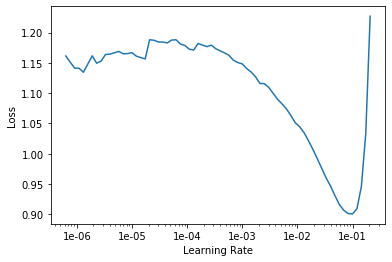

In [101]:
# find the learning rate using fast.ai library 
tr.lr_find(learn)
learn.recorder.plot()

__learning rate__: Here a learning rate from 1e-2 to 3e-2 seems good 

In [102]:
 
learn.fit_one_cycle(cyc_len = 80, max_lr = 0.03 , wd = 1e-4)

epoch,train_loss,valid_loss,time
0,0.065232,0.049954,00:26
1,0.056955,0.033080,00:25
2,0.053449,0.033012,00:26
3,0.048449,0.029238,00:25
4,0.045666,0.034843,00:26
5,0.046736,0.035995,00:24
6,0.038866,0.028820,00:26
7,0.039460,0.025831,00:25
8,0.037371,0.029376,00:26
9,0.034493,0.022529,00:26


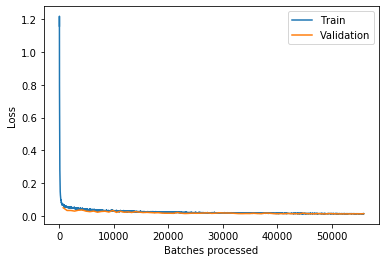

In [103]:
# plot the losses
learn.recorder.plot_losses()

### Plots for compressed data

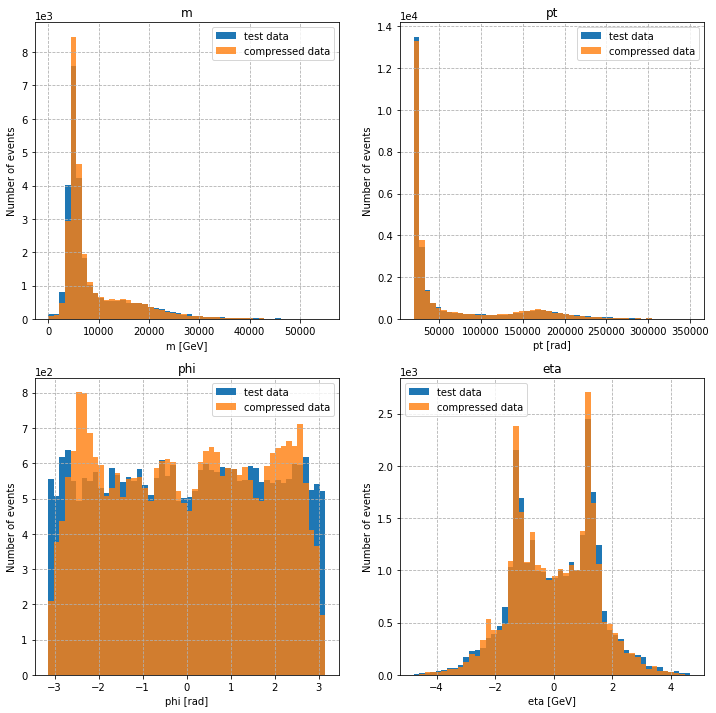

In [23]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
line_style = ['--', '-']
ranges = [(0, 55000), (20000, 350000), None,None]

test_x, test_y = test, test

data = (test_x.values)
# get compressed representation of test data
model.eval()
pred = model(next(iter(test_dl))[0].cuda()).detach().cpu().numpy()
# unnormalize the compressed data
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
# unormalize the test data
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

fig3 = plt.figure(figsize=(12, 12))
gs = fig3.add_gridspec(2, 2)

last = 0
n_bins = 50
for value in [0,1,2,3]:
    f3_ax1 = fig3.add_subplot(gs[last, value%2])
    n_hist_data, bin_edges, _ = f3_ax1.hist(data[:, value], label='test data', alpha=1, bins=n_bins, range = ranges[value])
    n_hist_pred, _, _ = f3_ax1.hist(pred[:, value], label='compressed data', alpha=0.8, bins=bin_edges)
    f3_ax1.set_title(test_x.columns[value])
    plt.xlabel(test_x.columns[value] + ' ' + unit_list[value])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()
    plt.grid(linestyle = '--')
    last = value %2
    if value == 2:
        last = 1



Here, compared to pre-trained network plots these seems much worse

### Plot residuals

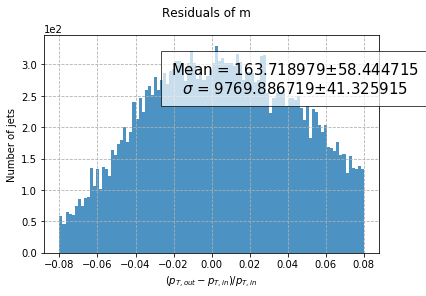

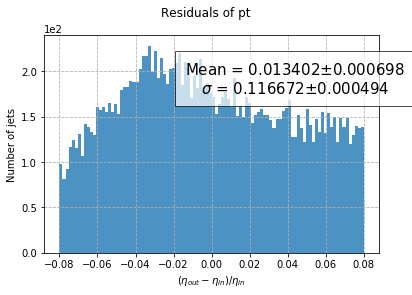

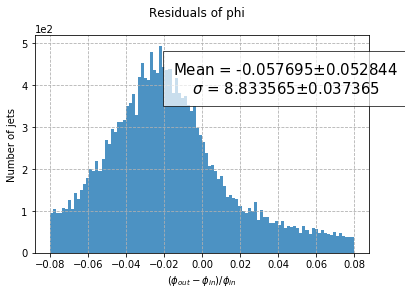

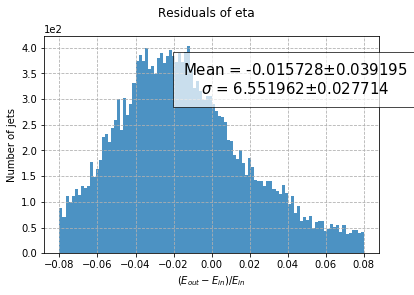

In [24]:
from network import std_error
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']

# calculate residuals between predictions and test data
data = np.where(data == 0., 1., data)
residuals = (pred - data) / data
range = (-.08, .08)

for value in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, value], label='Residuals', linestyle=line_style[0], alpha=0.8, bins=100, range= range)
    plt.suptitle('Residuals of %s' % train.columns[value])
    plt.xlabel(residual_strings[value])
    plt.ylabel('Number of jets')
    plt.grid(linestyle = '--')
    ms.sciy()
    
    # calculate stabdard deviation of residual
    std = np.std(residuals[:, value])
    std_err = utils.std_error(residuals[:, value])
    # calculate mean 
    mean = np.nanmean(residuals[:, value])
    sem = stats.sem(residuals[:, value], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)

As it could be seen from the graphs, 'm' variable has very large mean value and all the variables have large standard deviation, meaning compressed data and actual data is quite different. These plots gives us the idea that network did not do a good job at compressing the data and learning good representation of same.

Compared to the other experiment where I tried, using pre-trained network, these residuals are much worse. This indicates that pre-trained network on much bigger dataset performed better than training it from a scratch. 

<br>